# さらに深いモデル

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import init
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import utils

## Residual block

- 初期のresidual blockと、改良版のpre-activationのresidual blockのクラスをそれぞれ作成
    - 入力と出色のchannel数および畳み込みのstrideを引数にする
    - forwardメソッドを持ち、順伝播を実装する
    - 各畳み込み層はkernel_size=3, padding=1
- skip connectionによる接続はシンプルなtensorの加算なので、サイズが合ってないといけない
    - サイズが異なる場合は、残渣接続の前にkernel_size=1の畳み込み層およびBatch normを使ってサイズを合わせる
- 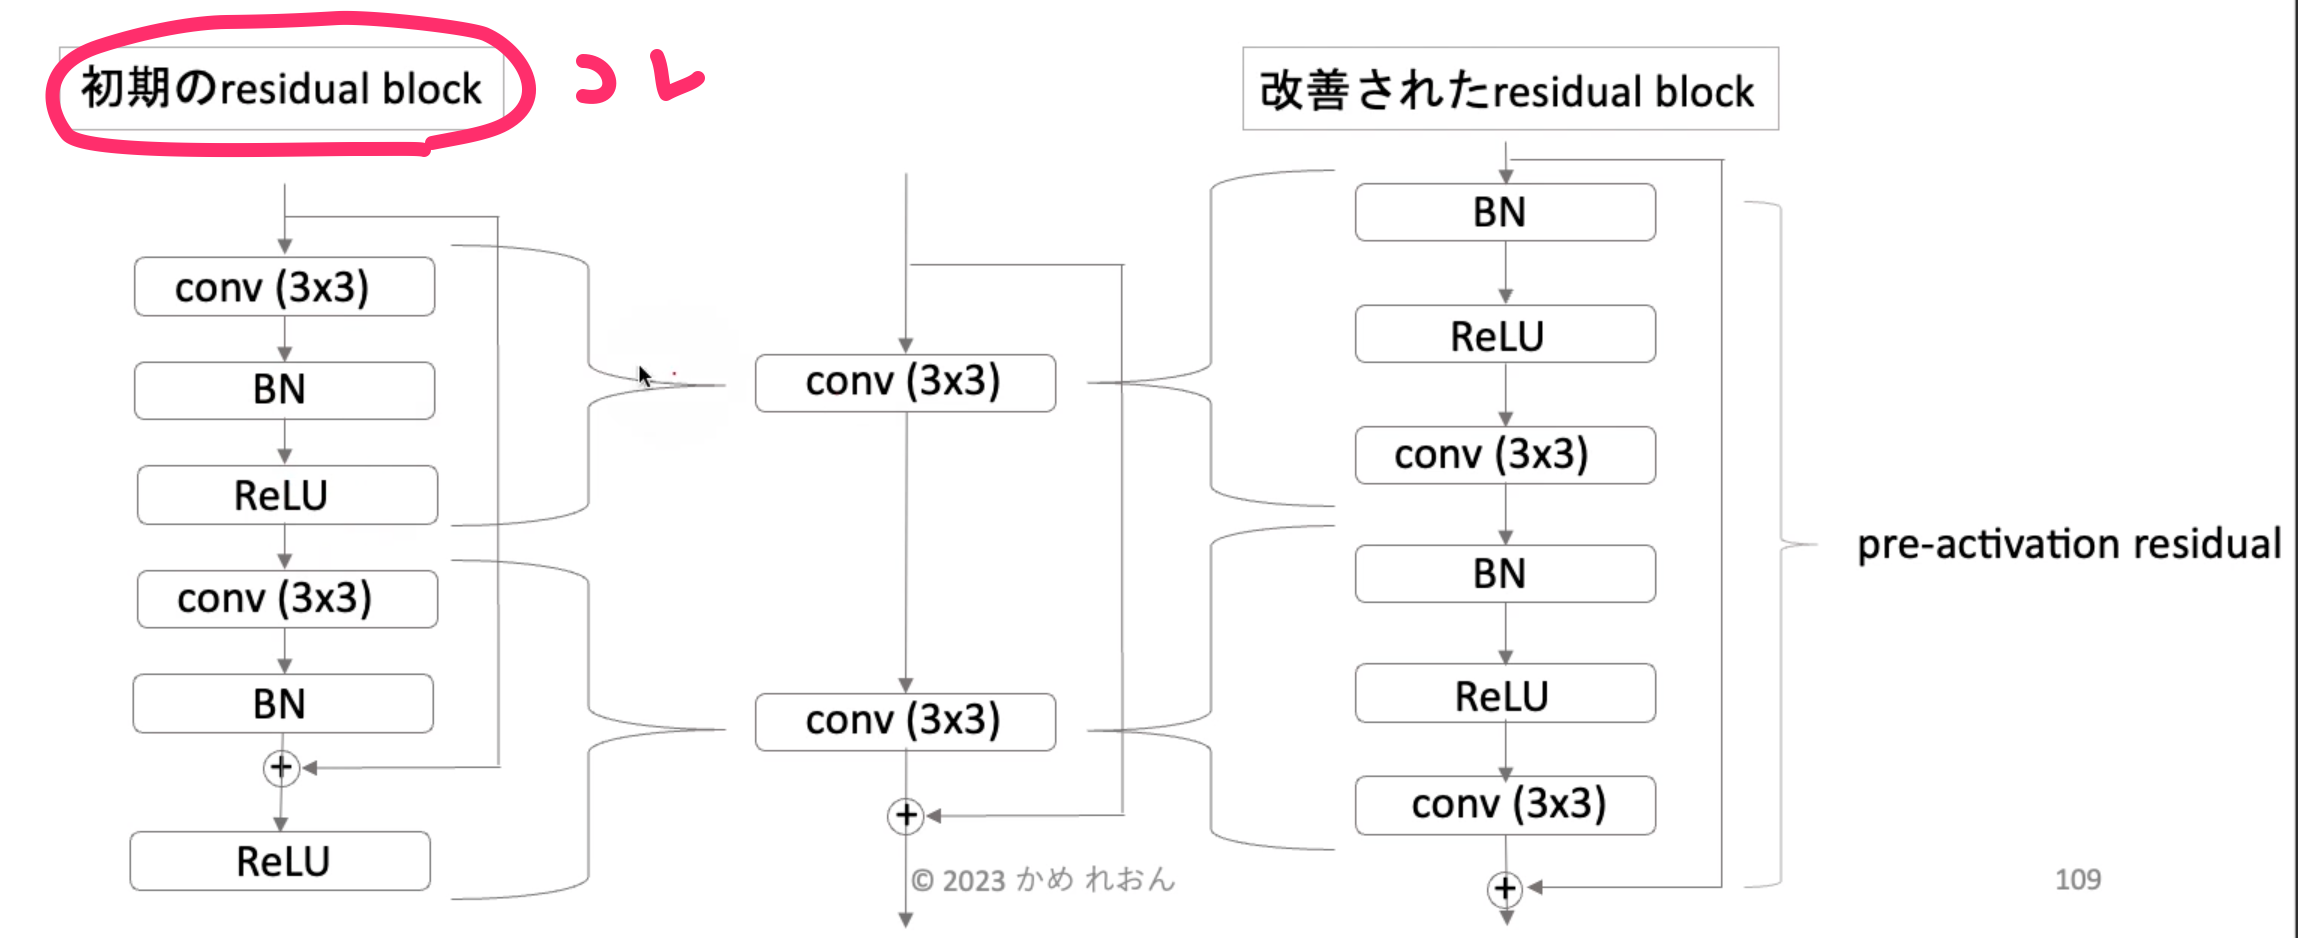

In [30]:
# 初期のResidual block
class ResidualBlock(nn.Module):
    
    def __init__(self, in_ch, out_ch, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()

        # あとでChatGPTに聞く
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, X):
        out = F.relu(self.bn1((self.conv1(X))))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(X)
        out = F.relu(out)
        return out

In [31]:
# stride=1のとき
resblock = ResidualBlock(3, 64, stride=1)

X = torch.randn(1, 3, 32, 32)
output = resblock(X)

output.shape

torch.Size([1, 64, 32, 32])

In [32]:
# stride=2のとき
resblock = ResidualBlock(3, 64, stride=2)

X = torch.randn(1, 3, 32, 32)
output = resblock(X)

output.shape

torch.Size([1, 64, 16, 16])

In [33]:
# 改良版 (Pre-Activation)
class PreActBlock(nn.Module):
    
    def __init__(self, in_ch, out_ch, stride):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_ch)  # BatchNormは出力を入れるので今だとin_ch
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.shortcut = nn.Sequential()

        # あとでChatGPTに聞く
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
            )

    def forward(self, X):
        out = F.relu(self.bn1((self.conv1(X))))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(X)
        out = F.relu(out)
        return out

In [34]:
# stride=1のとき
preact = ResidualBlock(3, 64, stride=1)

X = torch.randn(1, 3, 32, 32)
output = preact(X)

output.shape

torch.Size([1, 64, 32, 32])

## Bottleneck構造

### スクラッチ

- Bottleneck構造を採用したresidual blockのクラスを作成
    - blockへの入力channelと第1層目のconvの出力channel数、および畳み込みのstrideを引数にする
    - forwardメソッドで純伝搬で実装する
    - ※pre-activationである必要はない
    - 最終的な出力channelは第1層目のconv出力と出力channel数に対して4倍のchannel数とする
    - 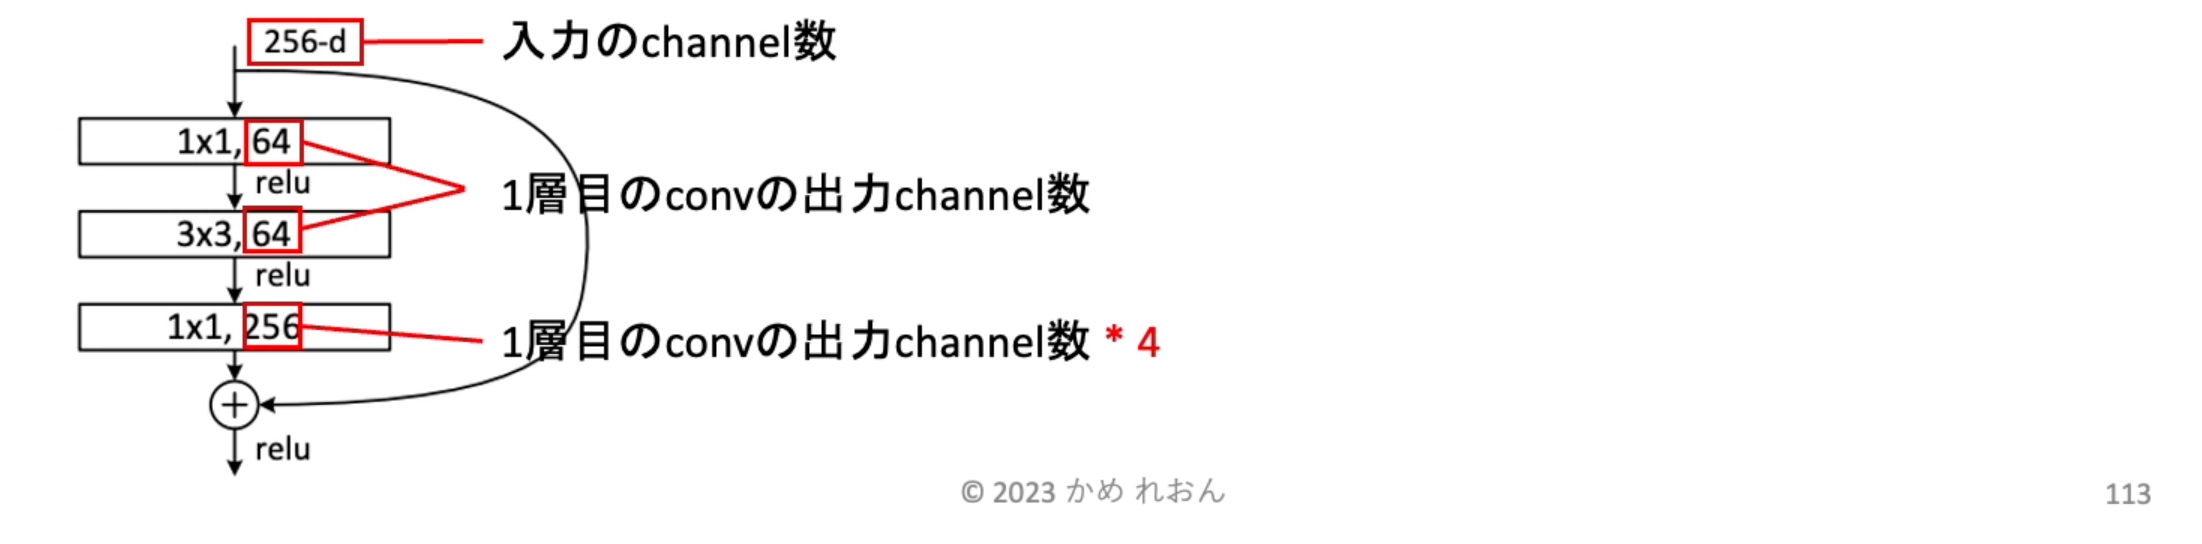

In [11]:
# point wiseは1x1のconv: パラメータ削減, 次元の変更に使う
# Bottleneck構造: 1x1conv -> 3x3conv -> 1x1convとすることで，channel数を減らして計算コストを削減する
class Bottleneck(nn.Module):

    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.expansion_factor = 4
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.conv3 = nn.Conv2d(out_ch, out_ch*self.expansion_factor, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_ch*self.expansion_factor)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_ch != out_ch*self.expansion_factor:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch*self.expansion_factor)
            )

    def forward(self, X):
        out = F.relu(self.bn1(self.conv1(X)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(X)
        out = F.relu(out)
        return out

In [15]:
# 順伝搬テスト
bottleneck = Bottleneck(256, 64, stride=2)
X = torch.randn(1, 256, 32, 32)
output = bottleneck(X)
output.shape

torch.Size([1, 256, 16, 16])

In [16]:
# 順伝搬テスト
bottleneck = Bottleneck(256, 64, stride=1)
X = torch.randn(1, 256, 32, 32)
output = bottleneck(X)
output.shape

torch.Size([1, 256, 32, 32])

In [17]:
# 通常の畳み込みで同様の出力サイズにする場合は以下のような畳み込みを使用する（計算コストが高い
output2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)(X)
output2.shape

torch.Size([1, 256, 32, 32])

## Inceptionモジュール

Inceptionモジュールのクラスを作成
- 入力channel数とそれぞれの畳み込み(1x1, 3x3, 5x5, pooling)の出力channel数を引数で受け取る
- point-wiseを使用し、パラメータ数を削減させる
- forwardメソッドを実装し、順伝播の処理を記載する
- それぞれの畳み込みの結果をchannel方向に結合させる
- 現論文ではpoint-wise convの出力channel数は、後続のconvやchannel数と異なる可能性があるが、ここでは簡素化のためにこれらのchannel数を一致させる
- 並列の処理は全てSequentialで記載する
- 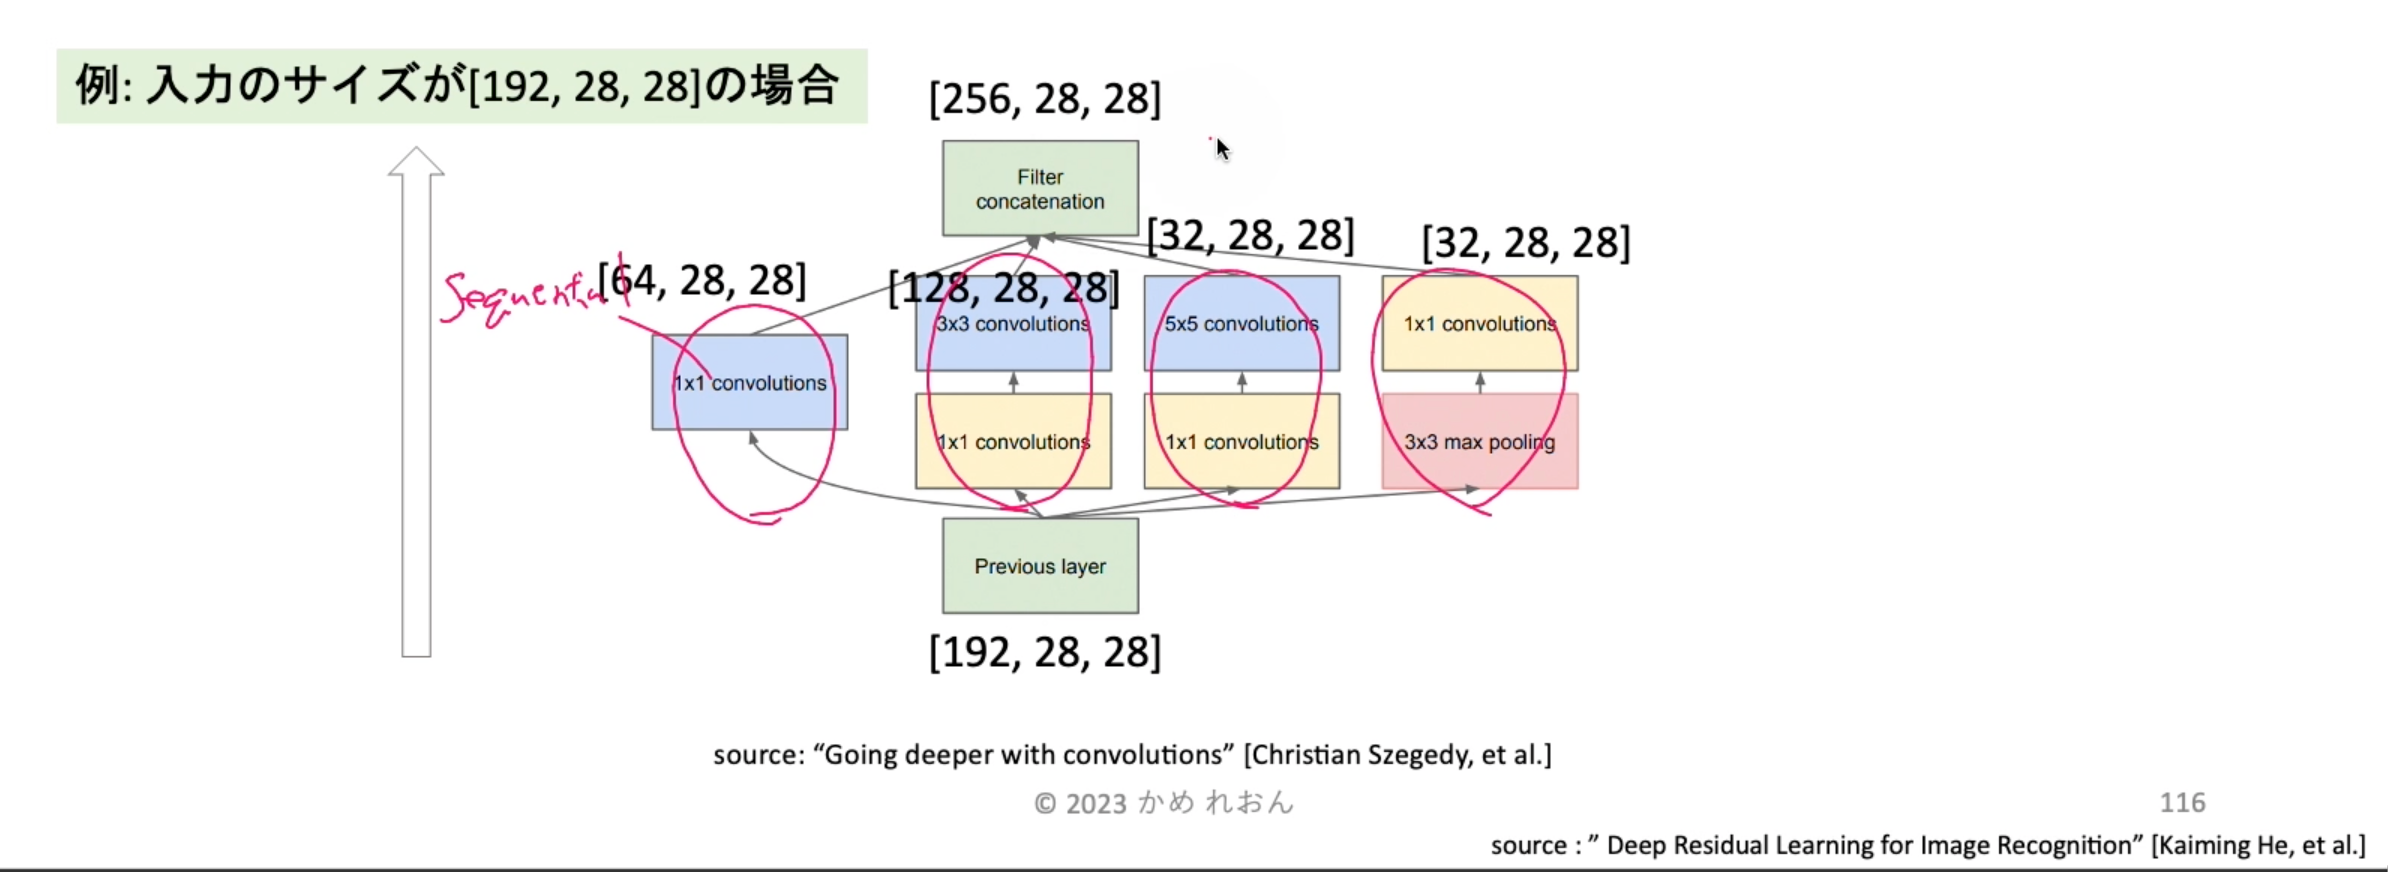

In [5]:
class InceptionModule(nn.Module):

    def __init__(self, in_ch, out_ch1, out_ch3, out_ch5, out_ch_pool):
        super().__init__()

        # 1x1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch1, kernel_size=1),
            nn.BatchNorm2d(out_ch1),
            nn.ReLU(),
        )

        # 3x3
        self.branch2 = nn.Sequential(
            # point-wise
            nn.Conv2d(in_ch, out_ch3, kernel_size=1),
            nn.BatchNorm2d(out_ch3),
            nn.ReLU(),
            # 3x3 conv
            nn.Conv2d(out_ch3, out_ch3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch3),
            nn.ReLU(),
        )

        # 5x5
        self.branch3 = nn.Sequential(
            # point-wise
            nn.Conv2d(in_ch, out_ch5, kernel_size=1),
            nn.BatchNorm2d(out_ch5),
            nn.ReLU(),
            # 5x5 conv
            nn.Conv2d(out_ch5, out_ch5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_ch5),
            nn.ReLU(),
        )

        # pooling
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_ch, out_ch_pool, kernel_size=1),
            nn.BatchNorm2d(out_ch_pool),
            nn.ReLU(),
        )
        
    def forward(self, X):
        branch1 = self.branch1(X)
        branch2 = self.branch2(X)
        branch3 = self.branch3(X)
        branch4 = self.branch4(X)

        return torch.cat([branch1, branch2, branch3, branch4], dim=1)
        

In [6]:
# InceptionModuleをテスト
X = torch.randn(16, 192, 28, 28)
module = InceptionModule(192, 64, 128, 32, 32)
out = module(X)
print(out.shape)

torch.Size([16, 256, 28, 28])


In [7]:
module

InceptionModule(
  (branch1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (branch2): Sequential(
    (0): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (branch3): Sequential(
    (0): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (branch4): Sequential(
    (0): Ma

In [4]:
a = torch.tensor([[1, 2, 3]])
b = torch.tensor([[4, 5, 6]])
print(a.shape)

ab_cat = torch.cat([a, b], dim=1) 
print(ab_cat)
print(ab_cat.shape)

torch.Size([1, 3])
tensor([[1, 2, 3, 4, 5, 6]])
torch.Size([1, 6])
